# Project 3 - Clothing Segmentation and Recommendation

## 1. Import Libraries

In [15]:
# Import the necessary libraries
import numpy as np
import glob
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers

## 2. Import Files

In [16]:
# Empty list to store the images
images = []
# Import images
for filename in sorted(glob.glob('Resources/images/*.png')):
    # Open and append image to list
    images.append(Image.open(filename))

In [17]:
# Empty list to store the image masks
masks = []
# Import image masks
for filename in sorted(glob.glob('Resources/masks/*.png')):
    # Open and append mask to list
    masks.append(Image.open(filename))

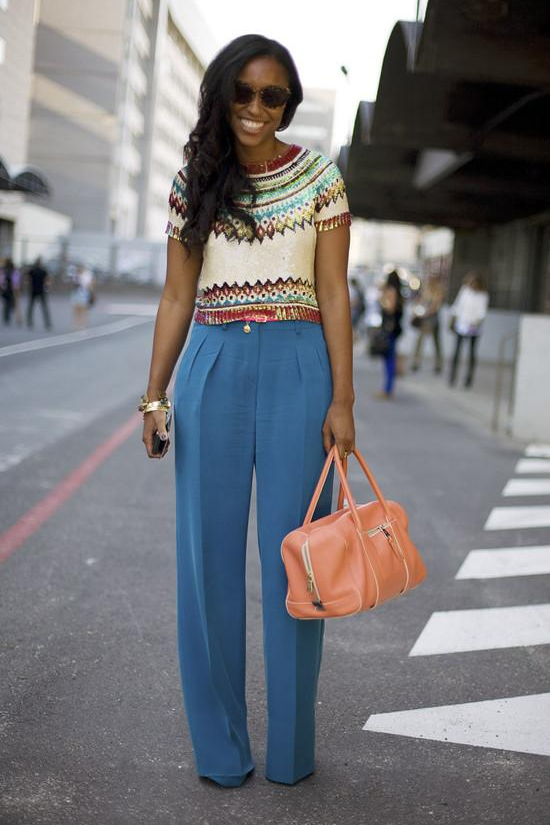

In [18]:
# Display the first image
images[500]

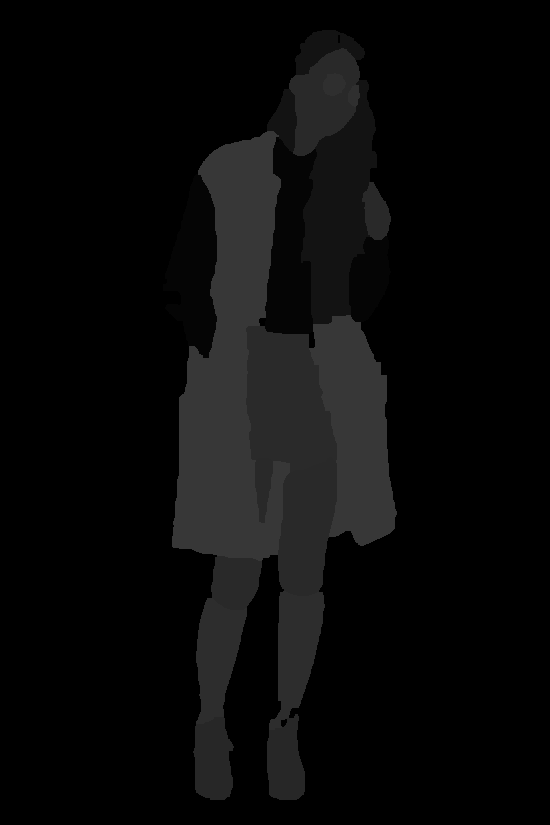

In [5]:
# Display the first corresponding mask
masks[0]

In [6]:
# Check the length of the datasets
len(images), len(masks)

(1000, 1000)

## 3. Model to identify object in the picture

### 3.1 Preprocessing

In [7]:
# Funtion to resize the images and masks
def resize_image(image, is_image):
   '''
   The function resizes the image/mask

   :param image: The image or mask that needs to be resized
   :type image: PngImageFile
   :param is_image: True if image / False if mask
   :type is_image: bool
   :return: image
   :rtype: tf.float32 (for image) or tf.uint8 (for mask)
   
   '''
   # Target size of the image
   target_size = (128,128)
   # If image
   if is_image:
      # Convert to floating point numpy arrays and normalize
      image = tf.cast(image, tf.float32) / 255
      # Resize the image
      image = tf.image.resize(image, target_size)
   else:
      image = np.expand_dims(image, axis=-1) 
      # Cast it
      image = tf.cast(image, tf.uint8)
      # Resize the image
      image = tf.image.resize(image, target_size, method="nearest")
      
   # Return the resized image or mask
   return image

In [8]:
# Resize images
images = [resize_image(image, True) for image in images]
# Resize masks
masks = [resize_image(mask, False) for mask in masks]

### 3.2 Augmentation

In [9]:
# Funtion to augment the images and masks
def image_augmentation(image, is_image):
    '''
    The function augments the images or masks

    :param image: The image/mask that needs to be resized
    :type image: tf.float32 (for image) or tf.uint8 (for mask)
    :param is_image: True if image / False if mask
    :type is_image: bool
    :return: augmentented_images
    :rtype: list
   
    '''
    
    # List to hold the augmentented images
    augmentented_images=[]

    # Augmentation for images only
    if is_image:
        # Adjust brightness
        augmentented_images.append(tf.image.adjust_brightness(image, 0.5))

        # Adjust contrast
        augmentented_images.append(tf.image.adjust_contrast(image, 0.5))

        # Adjust gamma
        augmentented_images.append(tf.image.adjust_gamma(image, 0.5))

        # Adjust hue
        augmentented_images.append(tf.image.adjust_hue(image, 0.5))

        # Adjust saturation
        augmentented_images.append(tf.image.adjust_saturation(image, 0.5))

    # Augmentation for masks only
    else:
        # The mask will be the same for images with different brightness,
        # contrast, gamma, hue, and saturation
        augmentented_images.extend([image for i in range(5)])

    # Flip the image horizontally
    augmentented_images.append(tf.image.flip_left_right(image))

    # Flip image vertically
    augmentented_images.append(tf.image.flip_up_down(image))

    # Rotate image 90 degrees
    augmentented_images.append(tf.image.rot90(image))

    # Rotate image 270 degrees
    augmentented_images.append(tf.image.rot90(image, -1))

    # Crop the image
    cropped_image = tf.image.central_crop(image, 0.8)
    # Resize after cropping
    cropped_image = tf.image.resize(cropped_image, (128,128))
    # Cast to integers as they are class numbers for masks
    if not is_image:
        cropped_image = tf.cast(cropped_image, tf.uint8)
    # Add cropped image to the list
    augmentented_images.append(cropped_image)

    # Return the list of augmented images
    return augmentented_images

In [10]:
# Create augmented images and masks
for i in range(1000):
    # Add augmented images to the images list
    images.extend(image_augmentation(images[i], True))
    # Add augmented masks to the masks list
    masks.extend(image_augmentation(masks[i], False))

In [11]:
# Chekc the length of the datasets
len(images), len(masks)

(11000, 11000)

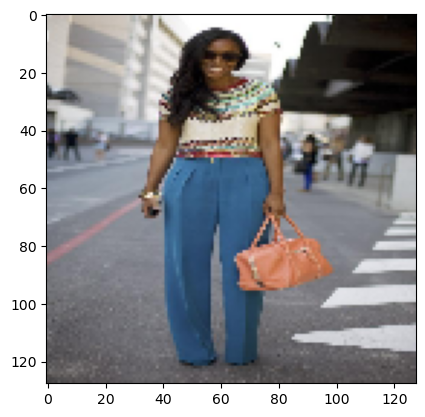

In [12]:
plt.imshow(images[500])

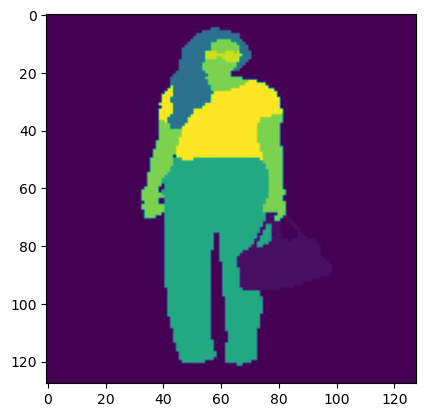

In [13]:
plt.imshow(masks[500])

## 4. CNN

In [23]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights="imagenet")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
layer_names = [
          "block_1_expand_relu", # 128 -> 64
          "block_2_expand_relu", # 64 -> 32
          "block_5_expand_relu", # 32 -> 16
          "block_8_expand_relu", # 16 -> 8
          "block_14_expand_relu", # 8 -> 4
      ]

In [25]:
layers = [base_model.get_layer(name).output for name in layer_names]

In [26]:
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [27]:
down_stack.trainable = False

## 5. Gradio/Steamlit app 